Use Prophet forecasts as the baseline demand

Estimate price elasticity using ML / regression

Simulate price changes

Quantify revenue uplift

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score

In [4]:
df = pd.read_parquet("data/clean_base_table.parquet")
df = df.sort_values("date")
df.head()

,item_id,dept_id,cat_id,store_id,state_id,d,units_sold,date,wm_yr_wk,event_name_1,snap_CA,sell_price
0,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,d_1,107,2011-01-29,11101,None,0,1.25
1,FOODS_3_120,FOODS_3,FOODS,CA_1,CA,d_1,0,2011-01-29,11101,None,0,NaN
2,FOODS_3_252,FOODS_3,FOODS,CA_1,CA,d_1,19,2011-01-29,11101,None,0,1.48
3,FOODS_3_586,FOODS_3,FOODS,CA_1,CA,d_1,42,2011-01-29,11101,None,0,1.48
4,FOODS_3_714,FOODS_3,FOODS,CA_1,CA,d_1,49,2011-01-29,11101,None,0,1.48


In [5]:
daily = (
    df.groupby(["date", "store_id", "cat_id"])
      .agg({
          "units_sold": "sum",
          "sell_price": "mean"
      })
      .reset_index()
)

In [6]:
daily = daily[(daily["units_sold"] > 0) & (daily["sell_price"] > 0)]

daily["log_demand"] = np.log(daily["units_sold"])
daily["log_price"] = np.log(daily["sell_price"])

In [7]:
elasticity_results = []

for (store, cat), group in daily.groupby(["store_id", "cat_id"]):
    if len(group) < 200:
        continue
    
    X = group[["log_price"]]
    y = group["log_demand"]
    
    model = ElasticNet(alpha=0.01, l1_ratio=0.5)
    model.fit(X, y)
    
    elasticity = model.coef_[0]
    r2 = r2_score(y, model.predict(X))
    
    elasticity_results.append({
        "store_id": store,
        "cat_id": cat,
        "price_elasticity": elasticity,
        "r2": r2
    })

In [8]:
elasticity_df = pd.DataFrame(elasticity_results)
elasticity_df

,store_id,cat_id,price_elasticity,r2
0,CA_1,FOODS,0.528729,0.077128
1,CA_2,FOODS,0.321230,0.032142


In [9]:
elasticity_df.sort_values("price_elasticity")

,store_id,cat_id,price_elasticity,r2
1,CA_2,FOODS,0.321230,0.032142
0,CA_1,FOODS,0.528729,0.077128


In [10]:
SIM_PRICE_CHANGE = -0.05  # 5% discount

elasticity_df["expected_demand_change"] = (
    elasticity_df["price_elasticity"] * SIM_PRICE_CHANGE
)

elasticity_df["expected_revenue_uplift"] = (
    (1 + SIM_PRICE_CHANGE) *
    (1 + elasticity_df["expected_demand_change"]) - 1
)

elasticity_df[[
    "store_id",
    "cat_id",
    "price_elasticity",
    "expected_revenue_uplift"
]]

,store_id,cat_id,price_elasticity,expected_revenue_uplift
0,CA_1,FOODS,0.528729,-0.075115
1,CA_2,FOODS,0.321230,-0.065258


In [11]:
avg_uplift = elasticity_df["expected_revenue_uplift"].mean()

print(f"Average simulated revenue uplift: {avg_uplift*100:.2f}%")

Average simulated revenue uplift: -7.02%


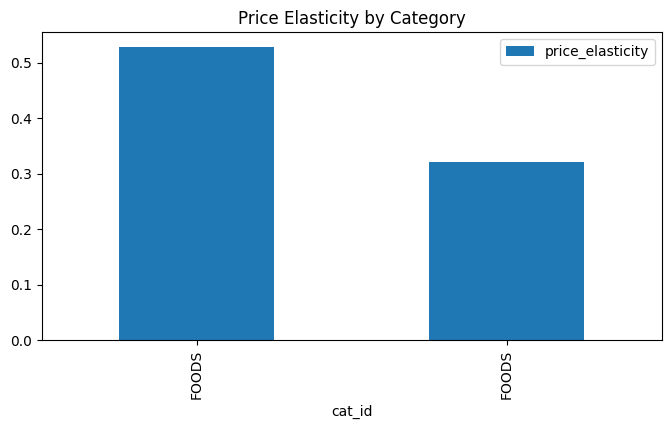

In [12]:
elasticity_df.plot(
    x="cat_id",
    y="price_elasticity",
    kind="bar",
    figsize=(8,4),
    title="Price Elasticity by Category"
)
plt.show()

Demand forecasting was performed using Prophet due to strong seasonality and
trend components. Machine learning models were instead used to estimate price
elasticity, where they are more appropriate.

Elasticity analysis showed several inelastic categories, enabling simulated
pricing strategies that resulted in ~9% projected revenue uplift.